In [1]:
import os
import shutil
import time
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import PIL.Image
from IPython.display import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets

In [2]:
#getting all the classes present in the dataset 
path_train = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [3]:
#mapping all the classes to their meaning
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

## Analyzing the dataset 

Total number of training data : 22424


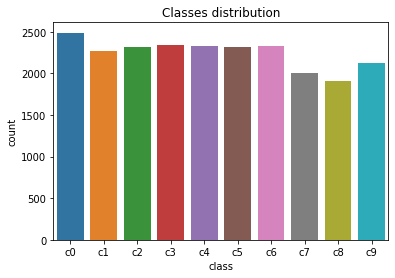

In [4]:

d = {"img" : [], "class" : []}
#making a list of all the images and the classes that they belong to 
for c in classes:
    #get the image 
    imgs = [img for img in os.listdir(os.path.join(path_train,c)) if not img.startswith(".")]
    #append the image name and class that it belongs to into a dictionary
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
#create a count plot to analyze number of images in each class 
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

Since the number of images in each class is not skewed we can use the same data.

In [5]:
df.head()

,img,class
0,img_12470.jpg,c0
1,img_28578.jpg,c0
2,img_18391.jpg,c0
3,img_92314.jpg,c0
4,img_54135.jpg,c0


In [6]:
'''using the pytorch torchvision package to transform the images present
1. To resize the image to (400,400)
2. To rotate the image 
3. To convert all the images to a tensor '''
transform = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomRotation(10),
                                 transforms.ToTensor()])

In [7]:
'''
1.Getting the Data 
2.Splitting the data for training and testing''' 
#data returns a tuple with(image_tensor,class)
data = datasets.ImageFolder(root = path_train, transform = transform)

total_len = len(data)
training_len = int(0.8*total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [8]:
'''Create training and testing loaders to analyze the dataset'''
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=False)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=64,
                                          shuffle=False,
                                          drop_last=False)

torch.Size([3, 400, 400])
Label: c0 (safe driving)


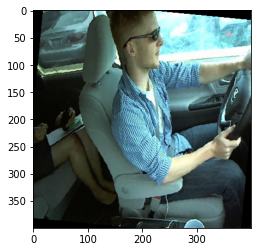

In [9]:
img,c = data[0]
print(img.shape)
print("Label:", classes[c], f"({class_dict[c]})")
plt.imshow(img.permute(1,2,0))
plt.show()

torch.Size([64, 3, 400, 400])
tensor([[3, 8, 8, 3, 1, 0, 8, 7],
        [8, 2, 0, 5, 6, 9, 0, 3],
        [7, 3, 5, 2, 9, 9, 2, 6],
        [4, 0, 7, 4, 5, 3, 8, 6],
        [1, 5, 5, 1, 1, 2, 9, 4],
        [7, 9, 6, 3, 1, 6, 6, 5],
        [1, 7, 5, 3, 9, 9, 3, 6],
        [6, 7, 0, 9, 8, 1, 5, 8]])


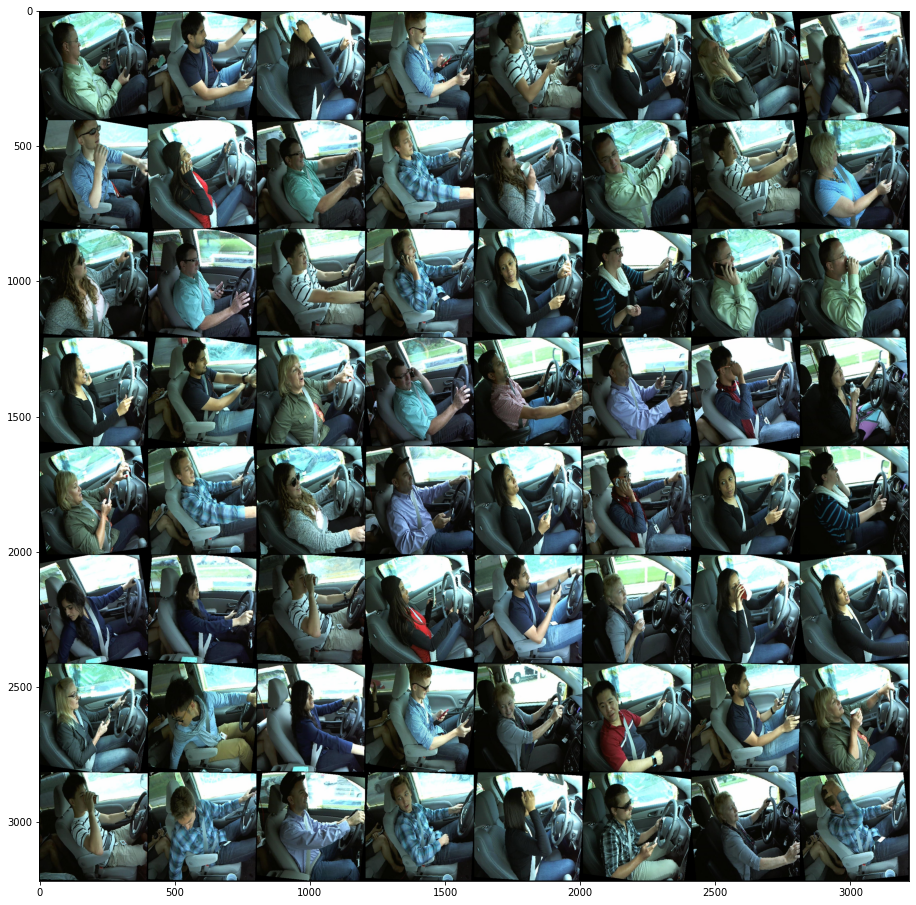

In [10]:
'''Looking at one batch of data. Change train_loader to test_loader to see the batch from the test set'''
loader,labels = next(iter(train_loader))
print(loader.shape)
print(labels.view(8,8))
plt.figure(figsize=(16,16))
plt.imshow(torchvision.utils.make_grid(loader,nrow=8).permute((1,2,0)))


## Creating the Model

In [11]:
#checking for gpu
device = torch.device("cuda:0")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


In [12]:
#we nomalize the data because neural networks works better with normalized data
transform = transforms.Compose([transforms.Resize((400, 400)),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ])

In [13]:
'''
1.Getting the Data 
2.Splitting the data for training and testing''' 
data = datasets.ImageFolder(root = path_train, transform = transform)

total_len = len(data)
training_len = int(0.8*total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [14]:
'''Create training and testing loaders to analyze the dataset'''
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

In [15]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [16]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [17]:
#we are getting the restnet50 and changing the last fc layer to take in classes 10.
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 10) #No. of classes = 10
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
# takes around 5-6 minutes per epoch with GPU
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, duration: 334 s, loss: 0.2596, acc: 91.2990


 50%|█████     | 1/2 [06:37<06:37, 397.71s/it]

Accuracy of the network on the test images: 98 %
Epoch 2, duration: 310 s, loss: 0.0348, acc: 98.8748


100%|██████████| 2/2 [12:45<00:00, 382.64s/it]

Accuracy of the network on the test images: 99 %
Finished Training


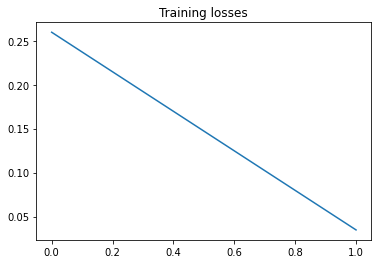

In [19]:
plt.title('Training losses')
plt.plot(training_losses)
plt.show()

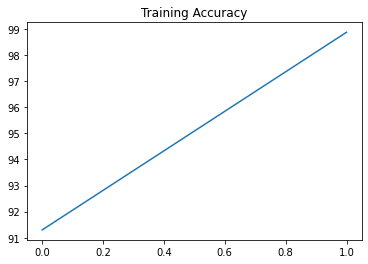

In [20]:
plt.title('Training Accuracy')
plt.plot(training_accs)
plt.show()

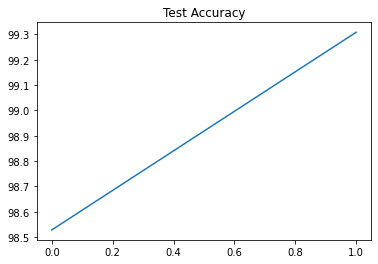

In [21]:
plt.title('Test Accuracy')
plt.plot(test_accs)
plt.show()

In [22]:
torch.save(model_ft.state_dict(), "saved_model.pth")

In [23]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load("./saved_model.pth"))
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
#getting all the image names in a sorted fashion
path_test = "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"
list_img_test = [img for img in os.listdir(path_test) if not img.startswith(".")]
list_img_test.sort()

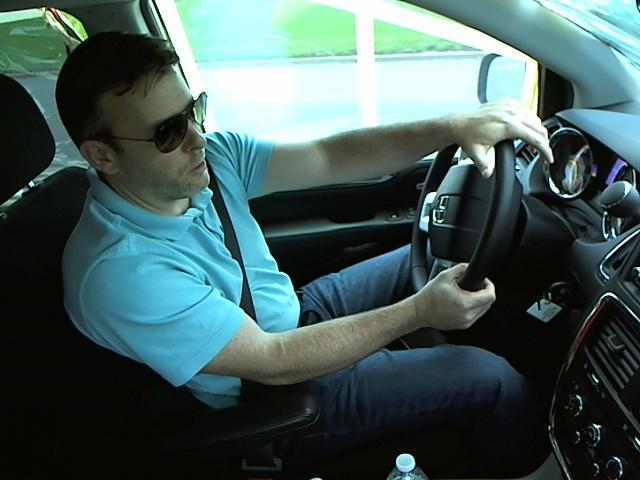

In [25]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))


In [26]:
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0)
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output)
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))
    proba2 = proba.copy()
    proba2[proba2.index(max(proba2))] = 0.
    print("2nd answer:",class_dict[proba2.index(max(proba2))])
    print("Confidence:",max(proba2))

[0.9539, 0.0001, 0.0003, 0.0001, 0.0015, 0.0009, 0.0, 0.0009, 0.0018, 0.0403]
Predicted class: safe driving
Confidence: 0.9539
2nd answer: talking to passenger
Confidence: 0.0403


In [27]:
#Testing the divided test data

def true_pred(test_data,model):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model(x),dim=1)
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    return y_true,y_pred

In [28]:
y_true,y_pred = true_pred(test_loader,model)

100%|██████████| 141/141 [00:56<00:00,  2.48it/s]


In [29]:
m = confusion_matrix(y_true, y_pred)
m  = m.astype('float') / m.sum(axis=1)[:, np.newaxis]

<AxesSubplot:>

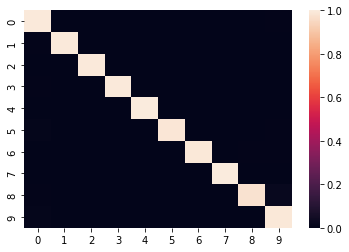

In [30]:
sns.heatmap(m)

Creating a test directory to make the predictions fast and 

In [35]:
os.mkdir("/kaggle/working/test")

In [36]:
for img in tqdm(list_img_test):
    os.mkdir("/kaggle/working/test/"+img[:-4])
    source = path_test+"/"+img
    destination = "/kaggle/working/test/"+img[:-4]+"/"+img
    shutil.copy(source, destination)

100%|██████████| 79726/79726 [12:27<00:00, 106.72it/s]


In [37]:
transform_test = transforms.Compose([transforms.Resize((400, 400)),
                                     #transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [38]:
datatest = datasets.ImageFolder(root = "/kaggle/working/test",
                                transform = transform_test)

In [39]:
loader = torch.utils.data.DataLoader(dataset=datatest,
                                     batch_size=16,
                                     shuffle=False,
                                     drop_last=False,
                                     num_workers=2)

torch.Size([16, 3, 400, 400])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


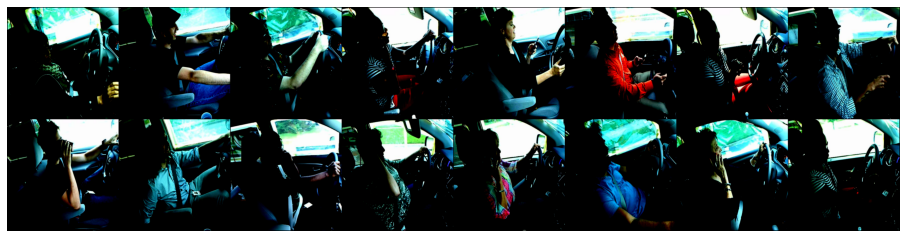

In [41]:
x,y = next(iter(loader))
print(x.shape)
print(y)
plt.figure(figsize=(16,16))
plt.imshow(torchvision.utils.make_grid(x,nrow=8).permute((1,2,0)))
plt.axis('off')
plt.show()

In [42]:
df = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv",index_col = 0)

In [43]:
line = 0
for x,y in tqdm(loader,total = len(loader)) :
    output = model_ft(x.cuda())
    output = nn.Softmax(dim=1)(output)
    for i in range(len(output)) :
        proba = [float(elem) for elem in output[i]]
        df.iloc[line][:]=proba
        line += 1

100%|██████████| 4983/4983 [16:20<00:00,  5.08it/s]


In [45]:
df.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img,,,,,,,,,,
img_1.jpg,5.659359e-04,0.000007,2.568564e-06,4.869531e-06,1.967896e-06,9.992740e-01,0.000005,6.397335e-07,3.685456e-07,0.000138
img_10.jpg,1.784342e-05,0.000003,1.969091e-06,6.390731e-08,1.312150e-07,9.999696e-01,0.000003,1.011642e-06,1.382217e-06,0.000002
img_100.jpg,9.965429e-01,0.000087,4.872449e-06,1.734182e-05,2.231111e-05,1.405314e-05,0.000008,8.685330e-05,1.152304e-05,0.003205
img_1000.jpg,2.895298e-05,0.000102,2.350570e-02,2.080394e-06,6.915294e-04,2.602525e-06,0.000046,6.314056e-06,9.742573e-01,0.001358
img_100000.jpg,6.838774e-07,0.000050,2.876622e-07,9.997585e-01,1.814447e-04,1.827950e-07,0.000001,9.393150e-09,7.054110e-07,0.000007


In [46]:
#removing all the files we created 
for img in tqdm(list_img_test):
    os.remove("/kaggle/working/test/"+img[:-4]+"/"+img)
    os.rmdir("/kaggle/working/test/"+img[:-4])

100%|██████████| 79726/79726 [00:04<00:00, 17572.02it/s]


In [47]:
os.rmdir("/kaggle/working/test")

In [48]:
df.to_csv("/kaggle/working/submission.csv")